In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 1: Data Summary

In [2]:
## Load data.
data = read_csv(os.path.join('data','study03','data.csv'))

## Format data.
data['logrt'] = np.log(data.rt)

#### 1.1 Item content

Number of items by dimension

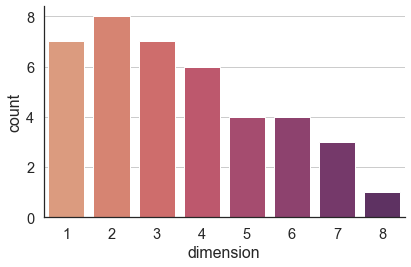

In [3]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))
palette = sns.color_palette('flare', n_colors=data.dimension.nunique())

## Get unique list of items.
items = data[['item','dimension']].drop_duplicates()

## Plot number of items.
sns.countplot(x=items.dimension, palette=palette, ax=ax)
ax.set(yticks=np.arange(0,9,2))
ax.grid(axis='y')

sns.despine()
plt.tight_layout()

Number of subjects by item

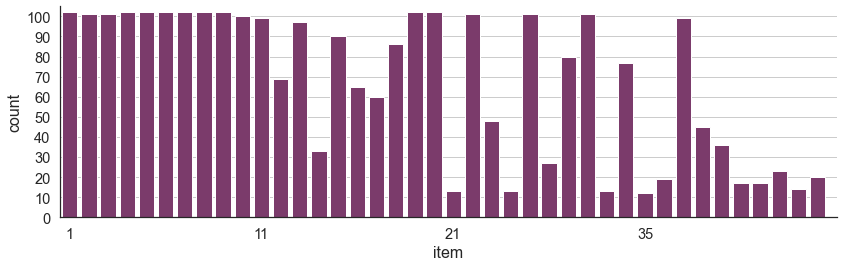

In [4]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot number of items.
sns.countplot(x=data.item, color='#863071', ax=ax)
ax.set(xticks=np.arange(0,41,10), yticks=np.arange(0,101,10), ylim=(0,105))
ax.grid(axis='y')

sns.despine()
plt.tight_layout()

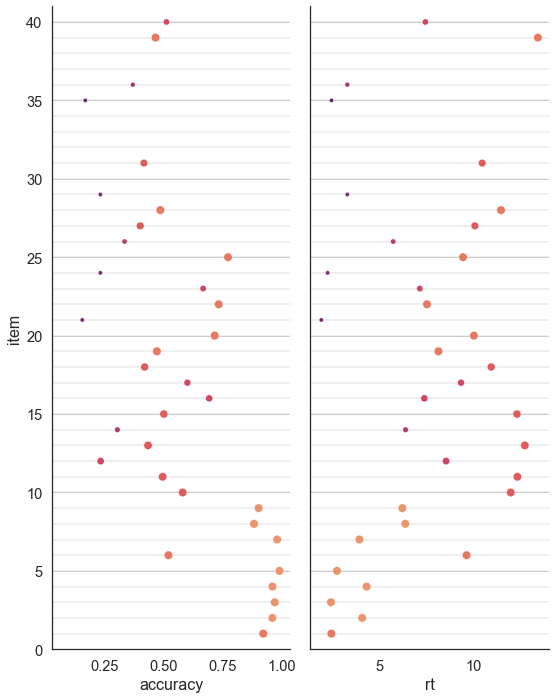

In [5]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(8,10),sharey=True)
palette = sns.color_palette('flare', n_colors=data.dimension.nunique())

## Compute averages. 
agg = {'accuracy':'mean','rt':'mean','subject':'count','dimension':'mean'}
gb = data.groupby('item').agg(agg).reset_index()

for ax, col in zip(axes, ['accuracy','rt']):
    
    ## Plot data
    sns.scatterplot(x=col, y='item', hue='dimension', size='subject', data=gb, 
                palette=palette, ax=ax)
    
    ## Add detail.
    x1, x2 = ax.get_xlim()
    ax.hlines(np.arange(data.item.nunique())+1, x1, x2, color='0.5', lw=0.25, zorder=-1)
    ax.set(xlim=(x1,x2), ylim=(0,41))
    ax.legend_.set_visible(False)
    ax.grid(axis='y')
    
sns.despine()
plt.tight_layout()

Table of items

In [6]:
gb.set_index('item').T

item,1,2,3,4,5,6,7,8,9,10,...,35,36,39,40,42,44,46,52,54,59
accuracy,0.921569,0.960396,0.970297,0.960784,0.990196,0.519608,0.980392,0.882353,0.901961,0.58000,...,0.166667,0.368421,0.464646,0.511111,0.444444,0.176471,0.352941,0.217391,0.071429,0.1000
rt,2.432118,4.072663,2.411564,4.308069,2.731363,9.623794,3.923980,6.363667,6.207294,11.97198,...,2.441167,3.280368,13.415424,7.433178,5.987500,3.157824,2.902588,5.095087,2.736786,3.6074
subject,102.000000,101.000000,101.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,100.00000,...,12.000000,19.000000,99.000000,45.000000,36.000000,17.000000,17.000000,23.000000,14.000000,20.0000
dimension,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.00000,...,8.000000,6.000000,2.000000,4.000000,4.000000,6.000000,6.000000,5.000000,6.000000,5.0000


#### 1.2 Speed-accuracy tradeoffs

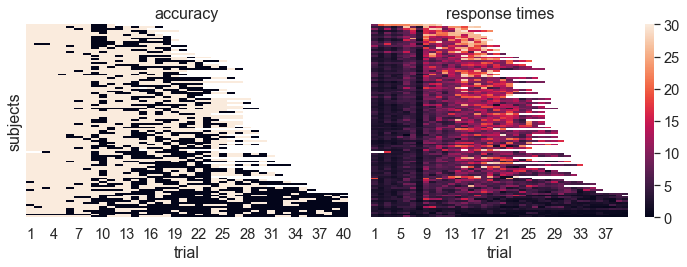

In [7]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(10,4))

## Pivot data (subject by trial).
pivot = data.pivot_table(['accuracy','rt'],'subject','trial')

## Sort data by RT.
pivot = pivot.loc[pivot['rt'].median(axis=1).sort_values(ascending=False).index]

## Plot accuracy.
sns.heatmap(pivot['accuracy'], vmin=0, vmax=1, yticklabels=[], cbar=False, ax=axes[0])
axes[0].set(ylabel='subjects', title='accuracy')

## Plot RTs.
sns.heatmap(pivot['rt'], vmin=0, vmax=30, yticklabels=[], ax=axes[1])
axes[1].set(ylabel='', title='response times')

plt.tight_layout()

Accuracy by RTs

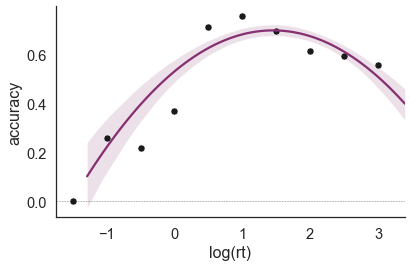

In [8]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Digitize RTs.
data['drt'] = np.digitize(data.logrt, np.arange(-1.75, 2.8, 0.5))
data['drt'] = data.drt.replace({i:j for i, j in enumerate(np.arange(-2,4,0.5))})

## Compute average accuracy by binned RT.
gb = data.groupby(['drt']).accuracy.mean().reset_index()

## Plot accuracy ~ logrt polynomial regression.
sns.regplot(x='logrt', y='accuracy', data=data, color='#863071', order=2, scatter=False, ax=ax)

## Plot observations.
sns.scatterplot(x='drt', y='accuracy', data=gb, s=50, color='k', ax=ax)

## Add detail.
ax.axhline(0, color='0.5', lw=0.5, linestyle='--', zorder=-1)
ax.set(xlabel='log(rt)')

sns.despine()
plt.tight_layout()

## Section 2: Effort-moderated 2PL

In [9]:
## Load and prepare StanFit summary.
summary = read_csv(os.path.join('stan_results', 'study03', '2pl_em_summary.tsv'), sep='\t', index_col=0)
summary = summary.T.filter(regex='(theta)|(beta)|(alpha)').T.reset_index()
summary = summary[['name','Mean']].rename(columns={'name':'param'})
summary['param'] = [s.split('[')[0] for s in summary.param]
summary.loc[summary.param=="alpha",'Mean'] = np.log(summary.loc[summary.param=="alpha",'Mean'])

## Load and prepare posterior predictive check.
ppc = read_csv(os.path.join('stan_results', 'study03', '2pl_em_ppc.tsv'), sep='\t')
ppc['w_bin'] = np.where(ppc['w_hat'] > 0.5, 1, 0)

#### 2.1 Posterior predictive check

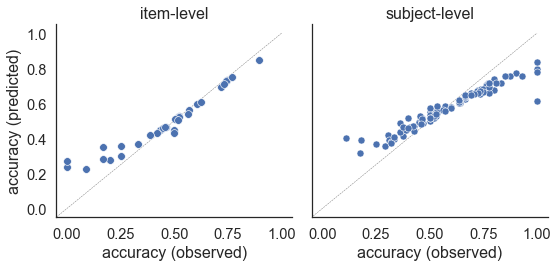

In [10]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(8,4),sharex=True,sharey=True)

## Compute groupby objects. 
agg = {'accuracy':'mean', 'Y_hat':'mean'}
gb1 = ppc.query('w_hat < 0.5').groupby('item').agg(agg)
gb2 = ppc.query('w_hat < 0.5').groupby('subject').agg(agg)

## Plot posterior check (items).
sns.scatterplot(x='accuracy', y='Y_hat', data=gb1, s=60, ax=axes[0])
axes[0].plot([-1,1], [-1,1], color='0.5', linestyle='--', lw=0.5, zorder=-1)
axes[0].set(xlim=(-0.05,1.05), xlabel='accuracy (observed)', ylim=(-0.05,1.05), 
            ylabel='accuracy (predicted)', title='item-level')

## Plot posterior check (subject).
sns.scatterplot(x='accuracy', y='Y_hat', data=gb2, s=50, ax=axes[1])
axes[1].plot([-1,1], [-1,1], color='0.5', linestyle='--', lw=0.5, zorder=-1)
axes[1].set(xlim=(-0.05,1.05), xlabel='accuracy (observed)', ylim=(-0.05,1.05), 
            ylabel='accuracy (predicted)', title='subject-level')

sns.despine()
plt.tight_layout()

#### 2.2 Parameter estimates 

/Users/szoro/Documents/software/anaconda3.7/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 36.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


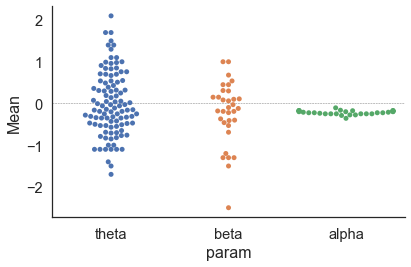

In [11]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Plot parameters.
sns.swarmplot(x='param', y='Mean', data=summary)
ax.axhline(0, color='0.5', lw=0.5, linestyle='--', zorder=-1)

sns.despine()
plt.tight_layout()

#### 2.3 Guessing estimates

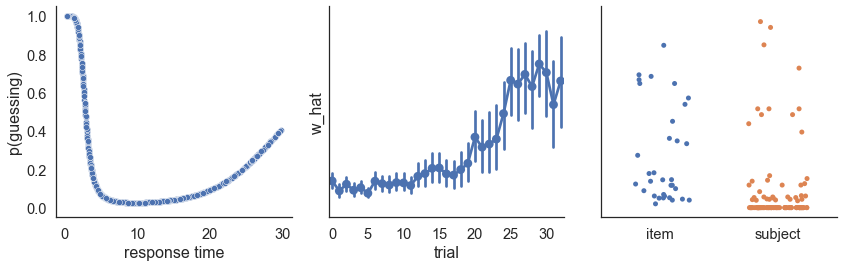

In [12]:
from pandas import concat

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4),sharey=True)

## Compute guessing by item / subject.
gb1 = ppc.groupby('item').w_bin.mean().reset_index(); gb1['cat'] = 'item'
gb2 = ppc.groupby('subject').w_bin.mean().reset_index(); gb2['cat'] = 'subject'
gb = concat([gb1[['cat','w_bin']], gb2[['cat','w_bin']]])

## Plot guessing function.
sns.scatterplot(x='rt', y='w_hat', data=ppc, ax=axes[0])
axes[0].set(xlabel='response time', ylabel='p(guessing)')

## Plot guessing by trial.
sns.pointplot(x='trial', y='w_hat', data=ppc, ax=axes[1])
axes[1].set(xticks=axes[1].get_xticks()[::5], xticklabels=axes[1].get_xticks()[::5])

## Plot guessing by item / subject.
sns.stripplot(x='cat', y='w_bin', data=gb, jitter=0.25, ax=axes[2])
axes[2].set(xlabel='', ylabel='')

sns.despine()
plt.tight_layout()